## Using Azure Machine Learning to Predict Profitability of Combined Cycle Power Plants 

##### A CCPP is a power plant that utilizes both gas and steam turbine for production of electricity, its working principle is same as that of the single-cycle power plant in the first half. So, in the first half, power is produced with the help of the gas turbine. The heat waste of the first process is utilized in the second half, in the steam turbine to produce the additional electricity. Diagram shown below for reference.

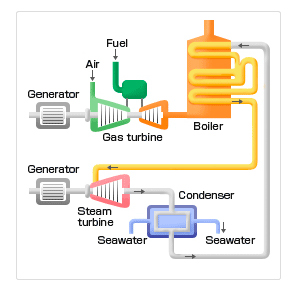

##### The primary purpose of using this power plant is to produce more electricity with higher efficiency. Therefore it is important to predict full load electrical power output of a base load power plant in order to maximise the profit from the available megawatt hours. Machine learning regression methods can be used to develop a predictive model. The base load operation is influenced by ambient temperature (AT) , atmospheric pressure (AP), relative humidity (RH) , and exhaust steam pressure (V).These will be our features and they affect electrical power (PE)  which will be our target. 

##### In this project, we take a look at the data collected from a Combined Cycle Power Plant (CCPP) over 6 years (2006-2011) when the power plant was set to work with full load. The averages are taken from various sensors located around the plant that record the ambient variables every second. 

##### Reference of data used:  https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

### 1. First to import relevant libraries and modules that will be used 

In [1]:
import time
import numpy as np 
import pandas as pd 
from sklearn.datasets import make_regression 

#For visualization 
import matplotlib.pyplot as plt  
import seaborn as sns
%matplotlib inline

#For statistics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

# The different algorithms
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Import the slearn utility to compare algorithms
from sklearn import model_selection,discriminant_analysis
from sklearn.model_selection import train_test_split 


 ### 2. Exploring dataset


#### We then import the dataset, it was divided into 5 files so we also have to merge the files based on their columns so that we can have a better look at it

In [2]:
# Five files from reference ( Each sheet in xlsx file was saved as a csv file as Azure does not accept xlsx files)
CCPP1 = pd.read_csv('CCPP1.csv')
CCPP2 = pd.read_csv('CCPP2.csv')
CCPP3 = pd.read_csv('CCPP3.csv')
CCPP4 = pd.read_csv('CCPP4.csv')
CCPP5 = pd.read_csv('CCPP5.csv')

# Can uncomment line below to see data before : 
# CCP5

CCPP = pd.concat([CCPP1,CCPP2,CCPP3,CCPP4,CCPP5], axis =0)

# Changing column names to more descriptive ones for easy readability and the columns are not alot
CCPP.columns = ['temperature','exhaust_vaccum','ambient_pressure', 'relative_humidity', 'electric_power']
CCPP

,temperature,exhaust_vaccum,ambient_pressure,relative_humidity,electric_power
0,14.96,41.76,1024.07,73.17,463.26
1,14.96,62.96,1020.04,59.08,444.37
2,14.96,39.40,1012.16,92.14,488.56
3,14.96,57.32,1010.24,76.64,446.48
4,14.96,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,15.12,48.92,1011.80,72.93,462.59
9564,33.41,77.95,1010.30,59.72,432.90
9565,15.99,43.34,1014.20,78.66,465.96
9566,17.65,59.87,1018.58,94.65,450.93


##### a. In exploring the data we need to understand the data  statistical properties, so we plot the histograms to see how distributed it is and also we can use describe() to get more statistical properties. This is shown below

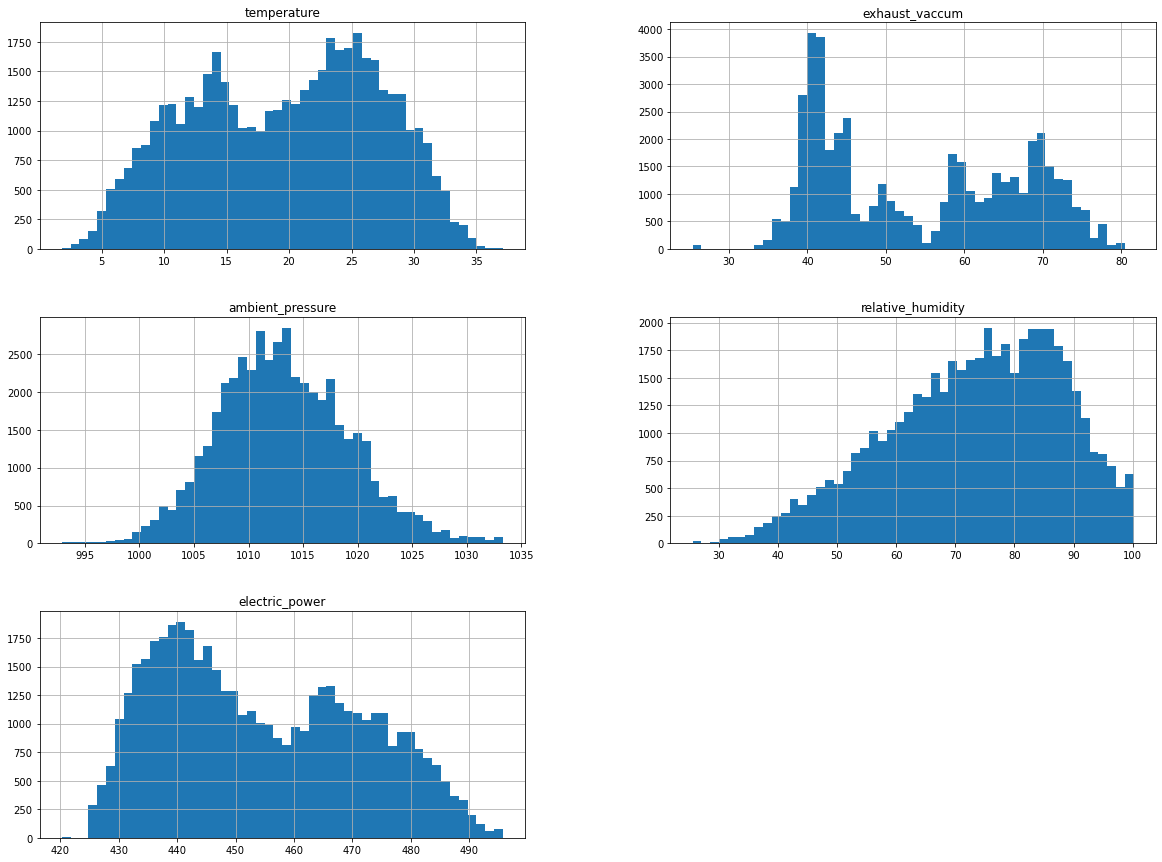

,temperature,exhaust_vaccum,ambient_pressure,relative_humidity,electric_power
count,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000
mean,19.650238,54.305804,1013.259078,73.308978,454.365009
std,7.451162,12.707362,5.938535,14.599658,17.066281
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.340000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [3]:
CCPP.hist(bins = 50,figsize=(20,15))
plt.show()
CCPP.describe()

#### As seen above the mean, standard deviation and quartiles of each feature is calculated and the histogram shows the distribution of the data. 

#### b. To get a better view of the distribution box plots can also be used. These could also identify outliers and if normalisation is needed

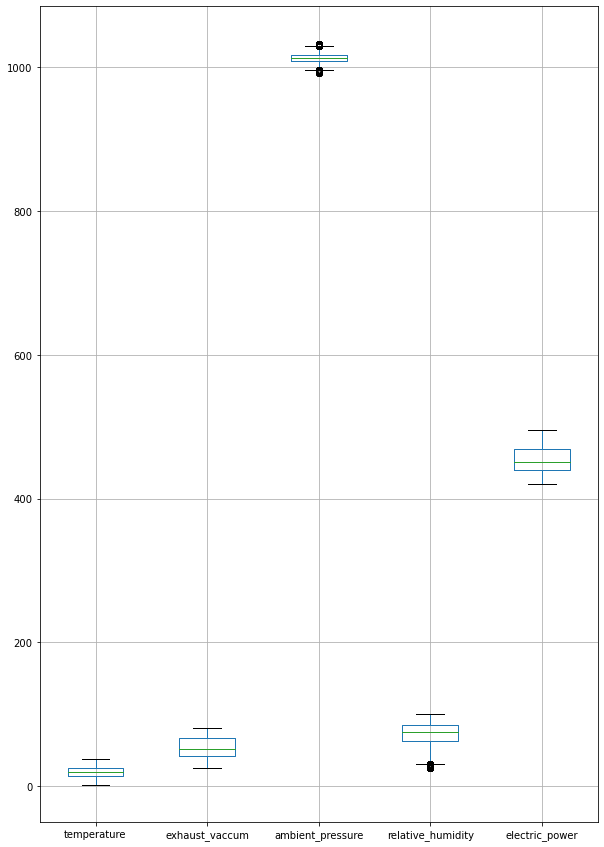

In [4]:
# Boxplot 
boxplot = CCPP.boxplot(column=['temperature','exhaust_vaccum','ambient_pressure', 'relative_humidity','electric_power'],figsize=(10, 15))  


#### The box plots and the histograms display the same properties but in the box plot we can clearly see where the mean is and the tails representing the maximum and minimum values of the features. But what we can also get from this graph is that the features do have different scales, for example, temperature, exhaust vaccum and relative humidity are around the same range ~ 0-200. But the ambient temperature is in the thousands so this can create errors. To bring down all the features to a common scale without distorting the differences, standardisation will be needed. 

#### We can also see that there are outliers in some features such as relative humidity and ambient pressure.


#### c. We also need to visualize the relationship between the features and the response. We can do this using scatterplots to get the general idea.

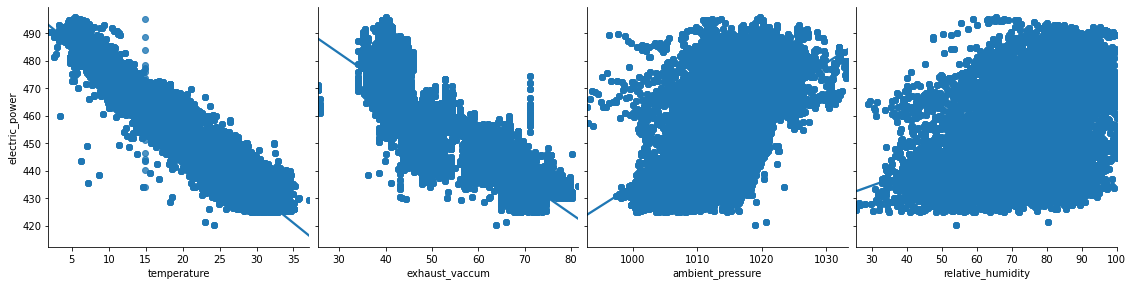

In [5]:
# Scatter plots 
sns.pairplot(CCPP, x_vars = ['temperature','exhaust_vaccum','ambient_pressure', 'relative_humidity'], y_vars =['electric_power'],kind = 'reg', height =4, aspect =1 ,dropna=True)


#### As seen above, temperature has a linear relationship with electric power. As the temperature increases, electric power decreases. 
#### Exhaust vaccuum also has the same relationship while ambient temperature and relative humidity although they have a positive correlation, the relationship is not as strong due to the standard deviation of the data being high.  This data is therefore suitable for regression models such as linear regression

#### d. To get the exact values of correlation, we can use a  correlation matrix. This will help us understand the correlation between different characteristics.The values range from -1 to 1 and the closer a value is to 1 the better correlation there is between two characteristics. A heat map has a similar function but only shows the data in a more presentable way with colours to show the relationship. 

#### Additionally these two methods show the relationship of one feature to all features.

                   temperature  exhaust_vaccum  ambient_pressure  \
temperature           1.000000        0.843986         -0.507588   
exhaust_vaccum        0.843986        1.000000         -0.413502   
ambient_pressure     -0.507588       -0.413502          1.000000   
relative_humidity    -0.542412       -0.312187          0.099574   
electric_power       -0.947928       -0.869780          0.518429   

                   relative_humidity  electric_power  
temperature                -0.542412       -0.947928  
exhaust_vaccum             -0.312187       -0.869780  
ambient_pressure            0.099574        0.518429  
relative_humidity           1.000000        0.389794  
electric_power              0.389794        1.000000  


<AxesSubplot:>

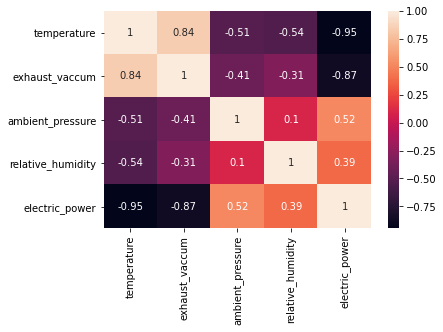

In [6]:
# Make a data correlation matrix. 
corr = CCPP.corr()
print (corr)

df_cor = CCPP.corr()
sns.heatmap(df_cor, xticklabels = df_cor.columns, 
            yticklabels = df_cor.columns, annot=True)

#### Therefore we can see  the relationship of all features and the target too. We can either look at the lower left corner or the upper right corner. In conclusion : 

#### - Electric power has the strongest correlation with temperature. The higher the power the lower the temperature.The second highest correlation is the exhaust vaccum. The higher the electric power, the lower teh exhaust vacuum. Then ambient tempertature and relative humidity have a positive correlation but a bit lower. This is understandable as we can see from the scatterplots that the data is very scattered. 

#### - For features that have a strong relationship we can see temperature and exhaust vaccum with a positive correlation of 0.84

### 3. Data cleaning/pre-processing 

#### In data cleaning and preprocesing, we will be checking for missing values, data types and removing outliers.
#### Outliers could act as noisy data and this will create errors in our model, and as the ouliers were not that many, the dataset will still be big enough for model evaluation

In [7]:
#Check for missing values 
np.any(np.isnan(CCPP))

False

In [8]:
# Checking data type, sometimes numbers are stored as strings 
# so we need to check to make sure that it is intigers as regression only recognises integers
CCPP.dtypes

temperature          float64
exhaust_vaccum       float64
ambient_pressure     float64
relative_humidity    float64
electric_power       float64
dtype: object

#### a. For outliers, first we look at ambient pressure 

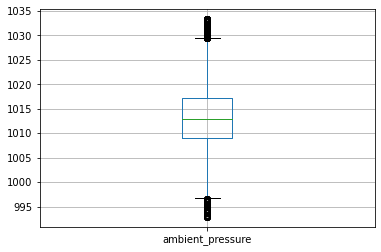

In [9]:
# to get a better view of the outliers we make the box plot again 
boxplot = CCPP.boxplot(column=['ambient_pressure'])

In [10]:
# We have to get rid of datapoints lower than the first quartile and higher that the third 

for x in ['ambient_pressure']:
    q75,q25 = np.percentile(CCPP.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    CCPP.loc[CCPP[x] < min,x] = np.nan
    CCPP.loc[CCPP[x] > max,x] = np.nan


In [11]:
# We can check and see that now we have nan values 
np.any(np.isnan(CCPP))

True

#### b. We then look at relative humidity

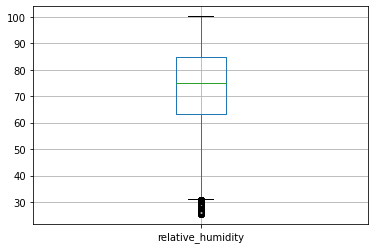

In [12]:
boxplot = CCPP.boxplot(column=['relative_humidity'])

In [13]:
# We have to get rid of datapoints lower than the first quartile ONLY

for x in ['relative_humidity']:
    q75,q25 = np.percentile(CCPP.loc[:,x],[75,25])
    intr_qr = q75-q25
    
    # max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    CCPP.loc[CCPP[x] < min,x] = np.nan
    #CCPP.loc[CCPP[x] > max,x] = np.nan


#### We the drop the columns with NaN values. We are dropping them because the data is not arranged in ascending or descending order so we cannot fill them with median values, 0 will be a false number as we saw earler that they have ranges of 0-200 and thousands. 

In [14]:
CCPP = CCPP.dropna()
# To check if we still have the NaN values : 
print(np.any(np.isnan(CCPP))) 

CCPP

False


,temperature,exhaust_vaccum,ambient_pressure,relative_humidity,electric_power
0,14.96,41.76,1024.07,73.17,463.26
1,14.96,62.96,1020.04,59.08,444.37
2,14.96,39.40,1012.16,92.14,488.56
3,14.96,57.32,1010.24,76.64,446.48
4,14.96,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,15.12,48.92,1011.80,72.93,462.59
9564,33.41,77.95,1010.30,59.72,432.90
9565,15.99,43.34,1014.20,78.66,465.96
9566,17.65,59.87,1018.58,94.65,450.93


#### By tracking the rows we see that now we have 47340 rows compared to earlier when we had 47840 rows. So we cleaned up the data by removing 500 rows. 

#### We can check the boxplot again to confirm there are no outliers. 

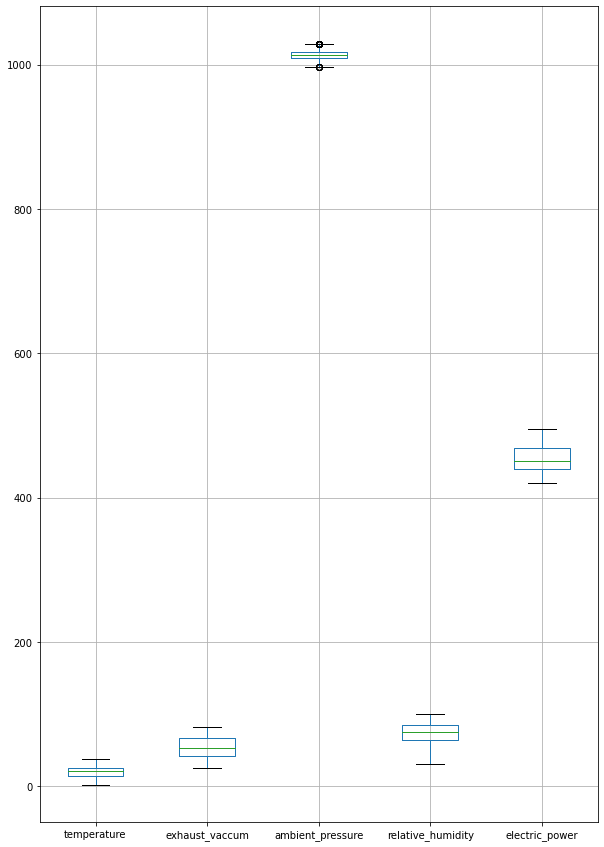

In [15]:
# Boxplot 
boxplot = CCPP.boxplot(column=['temperature','exhaust_vaccum','ambient_pressure', 'relative_humidity','electric_power'],figsize=(10, 15))  


#### We can also check what effect this has on correlation numbers which were low before for these two features with electric power

<AxesSubplot:>

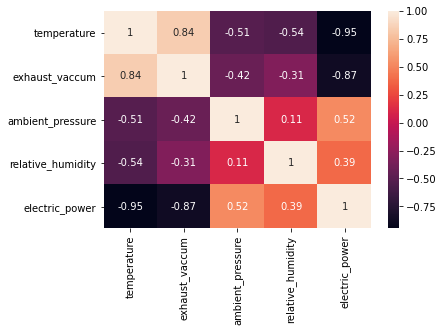

In [16]:
df_cor = CCPP.corr()
sns.heatmap(df_cor, xticklabels = df_cor.columns, 
            yticklabels = df_cor.columns, annot=True)

#### There was no change in the correlation numbers.

### 4. Training Models

#### The training models chosen for this project are linear regression, based on the relationship we saw from the scatter plots that showed a strong linear correlation between electric power, temperature and exhaust vaccum. We also use random forest regressors as they generally perform better. 


In [17]:
# Separating Data into X and y 
X = CCPP.drop(['electric_power'], axis = 1)
y = CCPP['electric_power']

# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2/3, random_state=0)

# Create the instance of the scaler
scaler = StandardScaler()

# Transform the inputs X
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


#### a. Linear Regression 

Intercept b: 454.1775373891001
Training accuracy: 0.9294159773004487
Test accuracy: 0.926869018651459
RMSE : 307.99607085329177
Variance score: -326.2647597122357


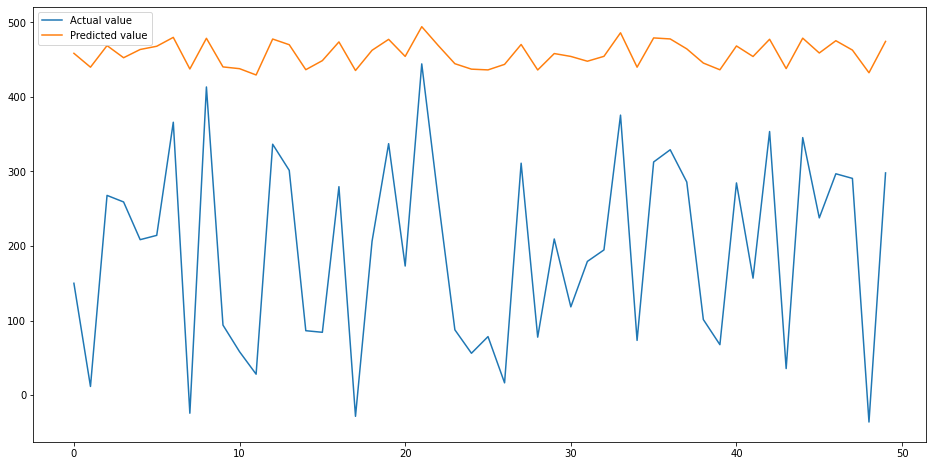

In [18]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
y_pred = linreg.predict(X_test)

print('Intercept b:', linreg.intercept_)
print('Training accuracy:', linreg.score(X_train_scaled, y_train))
print('Test accuracy:', linreg.score(X_test_scaled, y_test))
print('RMSE :',np.sqrt(mean_squared_error(y_test,y_pred)))
print('Variance score:', r2_score(y_test,y_pred))

test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
fig = plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual value','Predicted value'])


#### b. Random Forest Regressor

Training accuracy: -4.531046153345487
Test accuracy: -4.523990068357744
RMSE : 1.8865888200414114
Variance score: 0.987720988587255


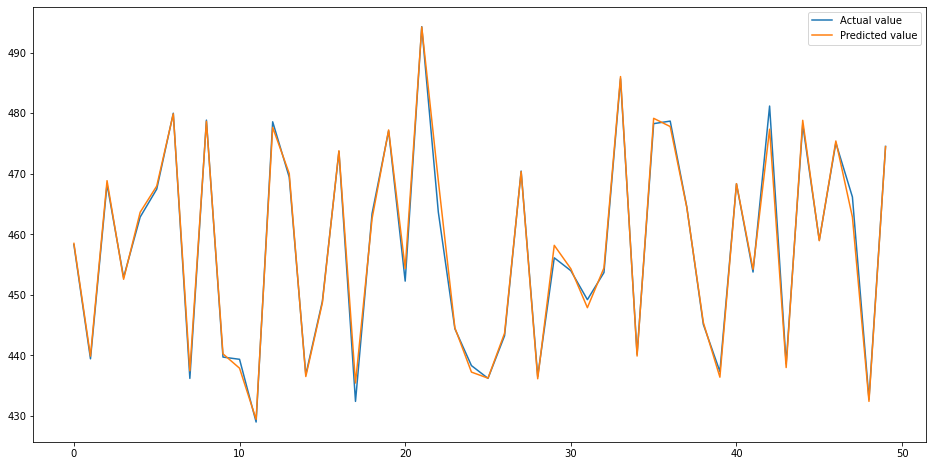

In [19]:
forest = RandomForestRegressor(criterion='mse')
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

print('Training accuracy:', forest.score(X_train_scaled, y_train))
print('Test accuracy:', forest.score(X_test_scaled, y_test))
print('RMSE :',np.sqrt(mean_squared_error(y_test,y_pred)))
print('Variance score:',r2_score(y_test,y_pred))

test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
fig = plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual value','Predicted value'])


#### Conclusion: As seen from the figures and mse values, decision tree regressor performs better at predicting the electric power . 

### 5. Hyperparameter tuning for algorithms

#### Since there are no hyperparameters for linear regression, first we can look at the impact that Cross-Validation has on the rmse values, to see if there is an improvement in the rmse value of linear regression compared to random forest regression. 

In [20]:
linreg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

In [21]:

regressors = {
    "RandomForestRegressor": RandomForestRegressor(),
    "LinearRegression": LinearRegression(),
}

df_models = pd.DataFrame(columns=['model', 'run_time', 'RMSE', 'RMSE_CV'])

for key in regressors:
    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    scores = cross_val_score(model, 
                             X_train_scaled, 
                             y_train,
                             scoring="neg_mean_squared_error", 
                             cv=5)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred))),
           'RMSE_CV': round(np.mean(np.sqrt(-scores)))
    }
    df_models = df_models.append(row, ignore_index=True)

df_models

* RandomForestRegressor
* LinearRegression


,model,run_time,RMSE,RMSE_CV
0,RandomForestRegressor,1.08,2,2
1,LinearRegression,0.0,5,5


#### Therefore as seen above, cross validation did not change the values much but these models are not fine tuned to their best parameters so we need to fine tune them first. 

In [22]:
# To better understand random forest regressor parameters
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### For Random Forest Regression

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [24]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_scaled, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [27]:
# The most important arguments in RandomizedSearchCV are n_iter, 
# which controls the number of different combinations to try, and cv which is the number of folds to use 
# for cross validation (we use 100 and 3 respectively). 
# More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, 
# but raising each will increase the run time. Machine learning is a field of trade-offs, and performance 
# vs time is one of the most fundamental.
# We can view the best parameters from fitting the random search:

rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

#### Fitting model with best parameters

Training accuracy: -4.575383255594207
Test accuracy: -4.568316614410662
RMSE : 1.8733025802849486
Variance score: 0.9878933286617614


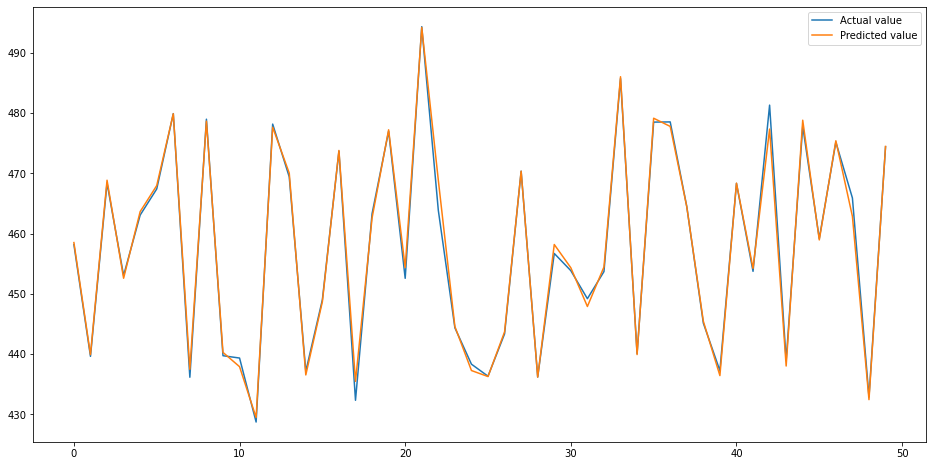

In [28]:
forest = RandomForestRegressor(criterion='mse',n_estimators = 400,min_samples_split = 2, min_samples_leaf= 1)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

print('Training accuracy:', forest.score(X_train_scaled, y_train))
print('Test accuracy:', forest.score(X_test_scaled, y_test))
print('RMSE :',np.sqrt(mean_squared_error(y_test,y_pred)))
print('Variance score:',r2_score(y_test,y_pred))

test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
fig = plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual value','Predicted value'])


#### The RMSE decreased by  (1.8735472794819024 - 1.8707169869483038) = 0.00283 or 0.15%